In [66]:
import msprime
import numpy as np
import pandas as pd
from IPython.display import SVG
import random
import demes
import demesdraw

In [ ]:
#! Model of American Admixture from Browning et al 2011
import math

T_OOA = 920

demography = msprime.Demography()
demography.add_population(name="AFR", description="African", initial_size=14474)
demography.add_population(
    name="EUR",
    description="European",
    initial_size=34039,
    growth_rate=0.0038,
)
demography.add_population(
    name="EAS",
    description="East Asian",
    initial_size=45852,
    growth_rate=0.0048,
)
demography.add_population(
    name="ADMIX",
    description="Admixed America",
    initial_size=54664,
    growth_rate=0.05,
)
demography.add_population(
    name="OOA",
    description="Bottleneck out-of-Africa",
    initial_size=1861,
)
demography.add_population(
    name="AMH", description="Anatomically modern humans", initial_size=14474
)
demography.add_population(
    name="ANC",
    description="Ancestral equilibrium",
    initial_size=7310,
)
demography.set_symmetric_migration_rate(["AFR", "EUR"], 2.5e-5)
demography.set_symmetric_migration_rate(["AFR", "EAS"], 0.78e-5)
demography.set_symmetric_migration_rate(["EUR", "EAS"], 3.11e-5)

demography.add_admixture(
    12,
    derived="ADMIX",
    ancestral=["AFR", "EUR", "EAS"],
    proportions=[1 / 6, 2 / 6, 3 / 6],
);

demography.add_population_split(T_OOA, derived=["EUR", "EAS"], ancestral="OOA")
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=["AFR", "OOA"], rate=15e-5
)
demography.add_population_split(2040, derived=["OOA", "AFR"], ancestral="AMH")
demography.add_population_split(5920, derived=["AMH"], ancestral="ANC")
#demography.debug()

<AxesSubplot:ylabel='time ago (generations)'>

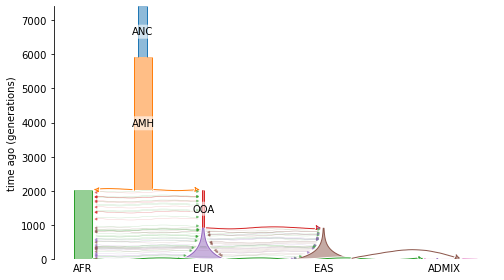

In [67]:
# Convert the demographic object to a demes graph.
test_graph = msprime.Demography.to_demes(demography)
# Visualize the demes graph.
demesdraw.tubes(test_graph)

In [87]:
""" Call ancestry simulation and add mutations """

model = msprime.SMM(lo=19, hi=27)
STR_mu = str(0.001569517) #CSF1PO
SNP_mu = str(2e-8)


def run_simis(num_samples, ancestry_seed, mutation_seed):
	"""
	Runs simulatiosn with given number of samples and ancestry seeds 
	"""
	
	# Call tree (ancestry) simulation using the demographic model
	ts = msprime.sim_ancestry(samples={"ADMIX": sample_size, "EUR": sample_size}, demography=demography, sequence_length=200001, recombination_rate=2e-8)	

	# Add mutations to the tree 
	snps = msprime.sim_mutations(ts, rate=SNP_mu, random_seed=ancestry_seed)
	strs = msprime.sim_mutations(ts, rate=STR_mu, model=model, random_seed=mutation_seed)
	return snps, strs


def copy_number_matrix(strs):
    """
    Returns the copy number matrix from the specified tree sequence
    simulated under a MicrosatMutationModel.
    """
    C = np.zeros((strs.num_sites, strs.num_samples), dtype=int)
    for var in strs.variants():
        alleles = np.array([int(allele) for allele in var.alleles])
        C[var.site.id] = alleles[var.genotypes]
    return C


In [121]:
""" Call helper function to run simulations and make computations """
# Parameters
num_replicates = 80
sample_sizes = [20, 40, 60, 80, 100]
#sample_size = 10

# Set random seeds
rng = np.random.RandomState(42)
seeds = rng.randint(1, 2**31, size=(num_replicates, 2))

dict_regression_results = {}
# For each sample size run reps
for sample_size in sample_sizes:
	# 1 if significant association, 0 otherwise
	eur_ = []
	adm_ = []
	for replicate_index in range(num_replicates):
		snps, strs = run_simis(sample_size, *seeds[replicate_index])
		str_geneExp = simulate_phenotype(snps, strs)
		eur, adm = regression_by_pop(str_geneExp, sample_size)
		eur_.append(eur)
		adm_.append(adm)
		
	dict_regression_results[sample_size] = [np.asarray(eur), np.asarray(adm)]

import matplotlib.pyplot as plt
## Plot results
for key in dict_regression_results:
	plt.plot(key, (np.sum(dict_regression_results[key][0])/num_replicates), label="eur")
	plt.plot(key, (np.sum(dict_regression_results[key][1])/num_replicates), label="adm")
	plt.legend()
	plt.show()

[22 26 24 22 26 27 22 21 26 24 27 26 23 23 26 26 27 24 23 27 19 27 27 27
 21 23 22 24 26 25 27 25 23 24 21 20 26 25 27 24 27 27 26 26 27 23 27 25
 27 27 25 27 26 27 26 25 27 25 27 24 26 26 27 26 26 25 25 27 26 27 26 27
 26 23 25 26 27 24 25 26]
CAusal after mean
[[0 0 0 0]
 [0 1 1 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]
CSF1PO after mean
[24.0, 23.0, 26.5, 21.5, 25.0, 26.5, 23.0, 26.0, 25.5, 25.0, 23.0, 27.0, 22.0, 23.0, 25.5, 26.0, 23.5, 20.5, 25.5, 25.5, 27.0, 26.0, 25.0, 26.0, 27.0, 26.0, 26.5, 25.5, 26.0, 25.5, 26.0, 26.5, 25.5, 26.0, 26.5, 26.5, 24.5, 25.5, 25.5, 25.5]
[23 26 25 22 25 22 25 27 24 20 27 23 

/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[20 20 27 20 23 20 23 23 23 26 23 22 24 23 21 21 24 19 24 24 20 21 19 19
 21 20 19 20 22 21 24 21 20 26 22 21 21 23 20 25 20 21 20 24 26 19 21 22
 19 21 21 19 19 21 24 22 25 22 19 20 19 26 22 21 26 21 25 22 21 22 22 22
 20 20 22 21 21 22 21 20]
CAusal after mean
[[1 1 2 1]
 [2 1 1 2]
 [1 1 2 1]
 [1 0 2 1]
 [2 1 1 2]
 [2 0 2 2]
 [2 0 2 2]
 [1 0 2 0]
 [1 1 2 1]
 [2 0 2 2]
 [1 0 2 1]
 [2 0 2 2]
 [2 0 2 2]
 [2 1 2 1]
 [1 0 2 1]
 [1 1 2 1]
 [1 2 1 1]
 [2 2 2 1]
 [1 1 2 0]
 [2 1 2 1]
 [1 0 2 0]
 [2 0 2 1]
 [2 1 1 1]
 [1 0 2 0]
 [2 0 2 1]
 [1 1 2 1]
 [1 0 2 1]
 [2 0 2 2]
 [2 0 2 2]
 [1 0 2 1]
 [1 1 1 0]
 [1 0 2 1]
 [2 1 1 1]
 [2 0 2 2]
 [1 1 2 1]
 [1 0 2 0]
 [1 0 2 0]
 [1 0 2 0]
 [1 1 2 0]
 [1 0 1 1]]
CSF1PO after mean
[20.0, 23.5, 21.5, 23.0, 24.5, 22.5, 23.5, 21.0, 21.5, 24.0, 20.5, 19.0, 20.5, 19.5, 21.5, 22.5, 23.0, 21.5, 22.0, 22.5, 20.5, 22.0, 22.5, 21.5, 20.0, 20.0, 20.0, 23.0, 23.5, 19.5, 22.5, 21.5, 23.5, 23.5, 21.5, 22.0, 20.0, 21.5, 21.5, 20.5]
[21 22 19 19 24 23 23 26 27 22 27 20 

/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[23 24 24 24 24 23 24 27 26 25 24 25 24 24 27 27 25 27 26 23 24 27 25 26
 24 24 27 26 24 26 22 27 26 26 25 24 26 26 24 25 24 24 22 26 25 27 26 26
 27 24 25 26 27 26 27 23 26 27 25 25 24 27 25 27 26 25 24 23 22 25 24 23
 24 24 26 23 24 27 27 23]
CAusal after mean
[[0 2 0 1]
 [1 2 2 0]
 [1 2 2 0]
 [1 1 1 1]
 [1 2 2 0]
 [0 2 2 0]
 [2 2 1 0]
 [2 0 0 2]
 [1 1 0 1]
 [1 1 1 1]
 [2 2 2 0]
 [1 1 1 0]
 [1 2 2 0]
 [1 1 0 2]
 [2 1 1 1]
 [2 1 0 2]
 [0 1 0 1]
 [1 1 0 2]
 [2 0 0 2]
 [0 2 1 1]
 [0 2 2 0]
 [0 2 1 1]
 [1 2 1 0]
 [1 2 1 0]
 [1 1 1 1]
 [0 2 2 0]
 [1 1 0 1]
 [0 2 2 0]
 [1 1 1 1]
 [0 2 2 0]
 [1 1 1 1]
 [1 1 2 0]
 [2 2 1 1]
 [0 2 1 1]
 [1 1 2 0]
 [1 2 1 0]
 [0 2 2 0]
 [1 1 0 2]
 [0 2 1 1]
 [1 1 1 1]]
CSF1PO after mean
[23.5, 24.0, 23.5, 25.5, 25.5, 24.5, 24.0, 27.0, 26.0, 24.5, 25.5, 25.5, 24.0, 26.5, 25.0, 24.5, 26.0, 24.5, 26.0, 24.5, 24.0, 24.0, 26.0, 26.0, 25.5, 25.5, 26.5, 25.0, 26.5, 25.0, 25.5, 26.0, 25.5, 23.5, 23.5, 23.5, 24.0, 24.5, 25.5, 25.0]
[19 19 20 20 21 19 19 21 22 19 22 21 

/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mayrabanuelos/anaconda3/envs/python3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[23 25 21 22 25 22 19 22 21 19 19 24 24 24 26 26 25 19 25 25 25 26 21 22
 19 20 20 20 22 19 20 20 22 26 27 20 19 24 27 24 27 25 22 25 20 25 23 21
 25 22 27 22 19 22 21 19 22 26 27 22 22 20 27 23 21 21 20 19 22 23 21 23
 19 22 27 25 21 27 27 21 19 20 26 22 22 24 23 19 27 19 23 21 21 19 21 19
 21 22 25 25 19 19 25 20 21 19 25 20 19 21 22 23 19 20 26 24 22 27 27 19
 19 26 23 19 20 19 21 25 19 22 21 23 19 27 27 21 27 21 22 20 20 27 22 27
 26 21 22 20 27 21 21 19 27 24 20 19 20 22 27 25]
CAusal after mean
[[1 2 0 0]
 [1 1 0 1]
 [0 2 0 0]
 [2 2 0 1]
 [1 1 1 0]
 [0 2 1 1]
 [0 2 1 0]
 [0 2 0 0]
 [1 2 0 1]
 [0 2 0 0]
 [1 2 1 0]
 [1 2 0 0]
 [1 2 0 1]
 [0 1 0 1]
 [1 2 1 2]
 [0 2 1 1]
 [0 2 0 0]
 [1 1 1 0]
 [0 1 1 0]
 [0 2 1 1]
 [0 2 1 0]
 [1 2 2 0]
 [1 1 1 0]
 [0 1 0 0]
 [2 2 0 2]
 [0 2 0 0]
 [0 1 0 0]
 [1 1 0 1]
 [0 2 1 0]
 [0 2 1 0]
 [0 1 0 1]
 [0 1 1 0]
 [2 1 1 1]
 [0 2 0 1]
 [0 2 1 0]
 [1 2 0 2]
 [1 2 0 0]
 [0 2 0 0]
 [0 2 2 0]
 [0 2 1 0]
 [2 1 0 0]
 [0 2 1 0]
 [0 2 1 0]
 [0 1 0 0]
 [0 1 0 0]

KeyboardInterrupt: 

In [101]:
def simulate_phenotype(snps, strs):
	str_list = []
	snp_list = []

	for str_ in strs.variants():
		str_list.append(str_.site.position)

	for snp_ in snps.variants():
		snp_list.append(snp_.genotypes)
	
	# Select STR 
	pos = [x for x in str_list if (x > 100000-2) & (x < 100000+2)]
	STR_pos = 100001

	C = copy_number_matrix(strs)
	CSF1PO1 = C[STR_pos]
	print(CSF1PO1)

	# Subset by SNPs that have at least 30% correlation with STR 
	cor = []
	for row in range(0, len(snp_list)):
		cor.append(abs(np.corrcoef(snp_list[row], CSF1PO1)[0,1]))

	pool_causal = [i for i, v in enumerate(cor) if(v > .30)]

	causal_index = random.choices(pool_causal, k=4)
	causal_snps = [snp_list[i] for i in causal_index]

	# Transposing to get data in ROWS = INDVIDUALS and COLS = SNPs
	# No Header or row names in matrix for phenotype simulation
	causal_snps1 = np.transpose(causal_snps)

	""" 
	Convert STR and SNPs into diploid by adding two adjacent haplotypes
	"""
	# We add adjacent rows for diploid genotypes
	causal_snps = (causal_snps1[::2] + causal_snps1[1::2])
	print("CAusal after mean")
	print(causal_snps)
	
	CSF1PO = []
	for ind in range(0, len(CSF1PO1), 2):
		CSF1PO.append((CSF1PO1[ind] + CSF1PO1[ind+1])/2)
	print("CSF1PO after mean")
	print(CSF1PO)
	
	# Get dimensions of matrix to set up for simulating an additive phenotype model
	# Standardize the values so that the variance of genetic and environmental components sum to 1
	ind, nsnps = causal_snps.shape[0], causal_snps.shape[1]
	Xmean = np.mean(causal_snps, axis=0)
	Xsd = np.std(causal_snps, axis=0, ddof=1)
	Xmarginal = (causal_snps - Xmean)/Xsd

	# Sample betas from normal distribution mean=0, std=1
	betas = np.random.normal(0, 1, size=nsnps)
	#betas = np.asarray([1.3839820, -0.8688081, 0.2746070, -0.3381371])
	pve=0.6
	### Simulate marginal (additive) effects ###
	y_marginal = np.matmul(Xmarginal, betas)
	betas = betas * math.sqrt(pve/np.var(y_marginal, ddof=1))
	y_marginal= np.matmul(Xmarginal, betas)

	""" NOTE: Each effect size for the marginal, epistatic, and random error effects are drawn from a standard normal distribution. Meaning beta ~ MVN(0,I) and epsilon ~ MVN(0,I). We then scale both the additive genetic effects so that collectively they explain a fixed proportion of genetic variance. Namely, the additive effects make up the narrow-sense heritability (or h^2). Once we obtain the final effect sizes for all causal SNPs, we draw errors to achieve the target 1-h^2.
	"""

	### Simulate residual error drawing noise from normal distribution ###
	y_err = np.random.normal(0, 1, size=ind)
	y_err = y_err * math.sqrt((1-pve)/np.var(y_err, ddof=1))

	#! Simulate gene expression 
	# Simulate the continuous phenotypes
	y = y_marginal + y_err
	
	return [np.asarray(CSF1PO), y]

## SHOULD I NORMALIZE THE STR VALUES AS WELL???

In [119]:
# REgressions
import statsmodels.api as sm

def regression_analysis(str_genos, exp):
	""" Performs Regression_Analysis 
		for STR genotypes (X) and simulated gene expression (Y)
		and returns p-value and correlation coefficient
	"""
	mod = sm.OLS(exp, str_genos)
	fii = mod.fit()
	p_value = fii.summary2().tables[1]['P>|t|'] 
	r = fii.rsquared

	return p_value, r

def regression_by_pop(str_phenotype, sample_size):
	# EUR should be second set of samples
	eur_str = str_phenotype[0][sample_size:]
	eur_exp = str_phenotype[1][sample_size:]

	# Regression of EUR samples
	Xmean = np.mean(eur_str)
	Xsd = np.std(eur_str, ddof=1)
	eur_m = (eur_str - Xmean)/Xsd
	pval_eur, rsqrd = regression_analysis(eur_m, eur_exp)

	# Regression adm samples
	adm_str = str_phenotype[0][:sample_size]
	adm_exp = str_phenotype[1][:sample_size]
	Xmean = np.mean(adm_str)
	Xsd = np.std(adm_str, ddof=1)
	adm_m = (adm_str - Xmean)/Xsd
	pval_adm, rsqrd = regression_analysis(adm_m, adm_exp)

	if pval_eur.to_list()[0] < 0.05:
		eur = 1
	else:
		eur = 0
	
	if pval_adm.to_list()[0] < 0.05:
		adm = 1
	else:
		adm = 0
	
	return eur, adm
